# ECOS2016

**29th INTERNATIONAL CONFERENCE**

on Efficiency, Cost, Optimisation, Simulation and Environmental Impact of Energy Systems

*June 19. - 23. 2016, Portorož, Slovenia*

http://www.ecos2016.si/

In [137]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import json
import time
import os

## Load dataset

Data was obtained for the test field Kromberk, from Elektro Primorska - partner in EU FP7 project Sunseed. Raw data was allready cleaned and enriched with various features. The process was described in detail in D4.2.1.

In [88]:
input_file_name = "nodes.json"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

sensors = pd.read_json(input_file_path)

In [156]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)

In [157]:
original_data[list(sensors.columns)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id12041022,139678,397.939288,326.812943,0,164,278.1,485.0,1549.2
id12041988,139678,50.623320,35.559386,0,25,35.0,73.0,343.0
id12041989,139678,347.315967,306.109999,0,130,226.0,433.5,1396.3
id12041991,139678,252.271014,255.045192,0,97,134.0,282.1,1148.2
id12041992,139678,101.993948,36.379970,0,73,101.0,127.0,266.0
id12041993,139678,78.774743,26.801117,0,58,80.0,98.1,191.0
id12041994,139678,34.632612,33.379006,0,12,18.0,58.0,311.0


## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [158]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

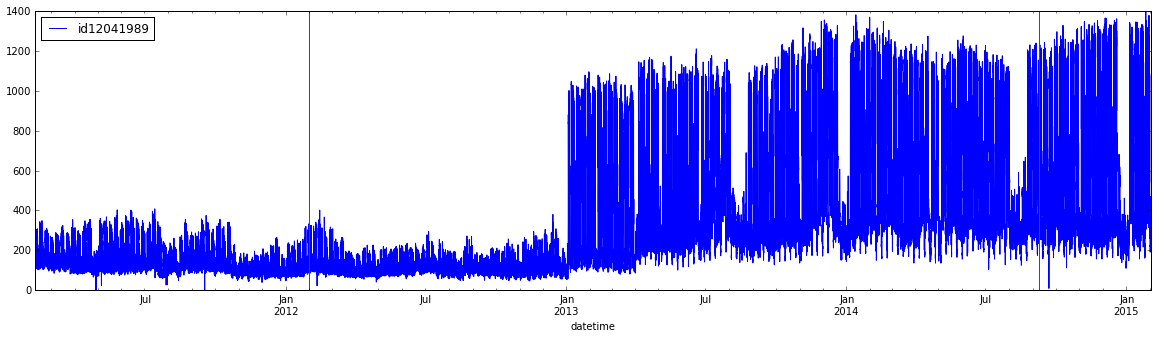

In [159]:
f = original_data[["id12041989"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Felatures and ML Models

In [188]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from naive_model import NaiveModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

## Creating Feature Sets

Define feature sets (loaded from file): 
- **autoregressive (AR):** autoregressive variables
- **wetaher_current (WC):** measured weather data
- **weather_forecasted (WF):** forecasted weather data
- **date_time (DT):** date time properties
- **top20 (TOP_20):** top 20 most importatnt features
- **top10 (TOP_10):** top 10 most important feautres
- **selected:**

In [189]:
input_file_name = "features.json"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

with open(input_file_path) as data_file:    
    features = json.load(data_file)
    
AR_WC_DT = features['autoregressive'] + features['wetaher_current'] + features['date_time']
TOP_20 = features['top20']

## Machine Learning Models

In [195]:
models = [{'name': "Baseline - Last value", 'init': "NaiveModel('measurement')"},
          {'name': "Baseline - Previous day", 'init': "NaiveModel('measurement_1d')"},
          {'name': "Baseline - Previous week", 'init': "NaiveModel('measurement_1w')"},
          #{'name': "Baseline - Measurement average", 'init': "NaiveModel('measurement_avr')"},
          #TODO: Local Average
          #{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          #{'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [#{'name': "AR", 'ftrs': ar_ftrs},
             #{'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             #{'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             {'name': "AR_WC_DT", 'ftrs': AR_WC_DT},
             #{'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             #{'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': TOP_20},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             #{'name': "SELECTED", 'ftrs': seleceted_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 {'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [196]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    sensor_list = list(sensors.columns)[0:3]

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        for horizon in range (1,25):
        #for horizon in range (1,2):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:       
                
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                                                                                    
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], X_train.shape, y_train.shape)

                for model in models: 
                    # Initializing model
                    mdl = eval(model['init'])

                    # Model leraning
                    start = time.time() # Start measuring time
                    if model['name'] == "Ridge Regression":
                        mdl.fit(X_train_dummy, y_train_dummy)
                    else:
                        mdl.fit(X_train,y_train)
                    runtime = time.time() - start # Calculate runtime

                    if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                    for metric in error_metrics:
                        #print "\t-->Error metric: {}".format(metric['name'])
                        
                        if model['name'][0:8] == 'Baseline':
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[mdl.target])
                            else:
                                error = metric['function'](y_test, testing_data[mdl.target])
                            
                        elif model['name'] == "Ridge Regression":
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                           y_test_dummy, mdl.predict(X_test_dummy))
                            else:
                                error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))
                                
                        else: 
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                           y_test, mdl.predict(X_test))
                            else:
                                error = metric['function'](y_test, mdl.predict(X_test))
                                
                        #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error
                        
                        if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

Working with sensor: id12041022

	-->Prediction horizont: 1h. Shifting runtime: 3.53s

		-->Dataset: AR_WC_DT. X_train: (91345L, 71L), y_train: (91345L,)
			-->Training model: Baseline - Last value, runtime: 0.00s
				-->R2: 0.821
				-->MAE: 93.677
				-->MSE: 26501.559
				-->MAPE: 14.697
				-->MASE: 1.561
			-->Training model: Baseline - Previous day, runtime: 0.00s
				-->R2: 0.179
				-->MAE: 225.157
				-->MSE: 121517.627
				-->MAPE: 43.191
				-->MASE: 3.752
			-->Training model: Baseline - Previous week, runtime: 0.00s
				-->R2: 0.564
				-->MAE: 150.961
				-->MSE: 64552.753
				-->MAPE: 26.530
				-->MASE: 2.516
			-->Training model: Random Forest, runtime: 82.12s
				-->R2: 0.943
				-->MAE: 59.515
				-->MSE: 8492.209
				-->MAPE: 9.846
				-->MASE: 0.992

		-->Dataset: TOP_20. X_train: (91345L, 20L), y_train: (91345L,)
			-->Training model: Baseline - Last value, runtime: 0.00s
				-->R2: 0.821
				-->MAE: 93.677
				-->MSE: 26501.559
				-->MAPE: 14.697
				-->MASE: 1.

KeyboardInterrupt: 

## Save Evalatuion Table

In [181]:
#TODO
output_file_name = "validationResults_TP.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

## Visualize 

In [197]:
validation_df

sensor                                    id12041022              \
error metric                                      R2         MAE   
horizon dataset  model                                             
1       AR_WC_DT Baseline - Last value      0.820878   93.677220   
                 Baseline - Previous day    0.178674  225.156646   
                 Baseline - Previous week   0.563694  150.961114   
                 Random Forest              0.942602   59.514537   
        TOP_20   Baseline - Last value      0.820878   93.677220   
                 Baseline - Previous day    0.178674  225.156646   
                 Baseline - Previous week   0.563694  150.961114   
                 Random Forest              0.944637   58.591620   
2       AR_WC_DT Baseline - Last value      0.614201  149.787081   
                 Baseline - Previous day   -0.007460  267.420464   
                 Baseline - Previous week   0.381720  194.902694   
                 Random Forest              0.922338   70.401676   
        TOP_20   Baseline - Last value      0.614201  149.787081   
                 Baseline - Previous day   -0.007460  267.420464   
                 Baseline - Previous week   0.381720  194.902694   
                 Random Forest              0.927506   68.774140   
3       AR_WC_DT Baseline - Last value      0.368844  206.402897   
                 Baseline - Previous day   -0.226857  312.486919   
                 Baseline - Previous week   0.156014  243.522074   
                 Random Forest              0.910285   75.995011   
        TOP_20   Baseline - Last value      0.368844  206.402897   
                 Baseline - Previous day   -0.226857  312.486919   
                 Baseline - Previous week   0.156014  243.522074   
                 Random Forest              0.920032   73.888095   
4       AR_WC_DT Baseline - Last value      0.146540  250.289338   
                 Baseline - Previous day   -0.428650  348.100862   
                 Baseline - Previous week  -0.052314  282.936121   
                 Random Forest              0.911126   78.755021   
        TOP_20   Baseline - Last value      0.146540  250.289338   
                 Baseline - Previous day   -0.428650  348.100862   
...                                              ...         ...   
21      AR_WC_DT Baseline - Previous week  -0.264778  321.258893   
                 Random Forest              0.898359   80.621280   
        TOP_20   Baseline - Last value     -0.068497  289.832643   
                 Baseline - Previous day   -0.561085  368.606708   
                 Baseline - Previous week  -0.264778  321.258893   
                 Random Forest              0.898776   80.799365   
22      AR_WC_DT Baseline - Last value      0.104863  252.498564   
                 Baseline - Previous day   -0.402750  337.009247   
                 Baseline - Previous week  -0.100604  287.485590   
                 Random Forest              0.898507   80.487071   
        TOP_20   Baseline - Last value      0.104863  252.498564   
                 Baseline - Previous day   -0.402750  337.009247   
                 Baseline - Previous week  -0.100604  287.485590   
                 Random Forest              0.891847   82.421279   
23      AR_WC_DT Baseline - Last value      0.243429  216.881615   
                 Baseline - Previous day   -0.277162  307.626547   
                 Baseline - Previous week   0.031505  255.332665   
                 Random Forest              0.905821   76.089363   
        TOP_20   Baseline - Last value      0.243429  216.881615   
                 Baseline - Previous day   -0.277162  307.626547   
                 Baseline - Previous week   0.031505  255.332665   
                 Random Forest              0.896466   79.613846   
24      AR_WC_DT Baseline - Last value      0.330174  178.372979   
                 Baseline - Previous day   -0.196144  277.108811   
                 Baseline - Previous week   0.111072  22